In [27]:
#load libraries
library(ggplot2)
library(speedyseq)
library(microbiome)
library(phyloseq)
library(tidyverse)
library(dplyr)
library(vegan)
library(lubridate)
library(PCAtools)
library(DESeq2)
library(GGally)
library(ggpmisc)
library(patchwork)
library(ggtext)
library(ggcorrplot)
library(ggplotify)
library(microViz)
library(qiime2R)
library(MicrobiomeStat)
library(ggsignif)
library(lme4)
library(lmerTest)
library(multcomp)
library(ggpubr)
library(lsmeans)
library('pbkrtest')
packageVersion("lme4")
packageVersion("multcomp")

[1] ‘1.1.35.5’

[1] ‘1.4.26’

In [2]:
# Load phyloseq object
load("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/ps_unpruned.RData")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 191539 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 13 sample variables ]:
tax_table()   Taxonomy Table:     [ 191539 taxa by 7 taxonomic ranks ]:
taxa are columns

In [3]:
#extract metadata file from phyloseq object 
meta=data.frame(sample_data(ps))  %>% as.data.frame() %>%
rownames_to_column("samp") %>%
mutate_at(vars(Sample.ID.file), 
             ~ stringr::str_replace_all(., pattern = "_S*", replacement = "")) %>%
mutate_at(vars(Sample.ID.file), 
            ~ stringr::str_replace_all(., pattern = "SWG", replacement = "")) %>%
column_to_rownames("Sample.ID.file")  %>%
  mutate(Site_Num = case_when(
    Site.Status == "Vulnerable" ~ 1,
    Site.Status == "Endemic" ~ 3,
    Site.Status == "Epidemic" ~ 2,
    TRUE ~ NA_integer_
  ))
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta)
dim(meta)

#write.csv(meta,"/Users/stephanie.rosales/Documents/Tissueloss/EPA2/meta_EPA2.csv")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,Site.Status,Month,Year,Site_Num
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<int>
CG.DSTO1.H,CG.DSTO1.H_S3,CG.DSTO1.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO3.H,CG.DSTO3.H_S3,CG.DSTO3.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO4.H,CG.DSTO4.H_S3,CG.DSTO4.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO5.H,CG.DSTO5.H_S3,CG.DSTO5.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO6.H,CG.DSTO6.H_S3,CG.DSTO6.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.SINT1.H,CG.SINT1.H_S3,CG.SINT1.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,SINT,Healthy,Epidemic,February,2020,2


[1] 360  14

In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta)


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
520.H,520.H_S18,520.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
521.H,521.H_S18,521.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,MCAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
522.H,522.H_S18,522.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,MCAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
523.H,523.H_S18,523.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,MCAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


In [5]:
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table)

dim(ASV_table)

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4af34e31f4f29f5372246db273985eb8,12,18,24,19,20,28,21,23,19,26,⋯,0,0,38,0,197,37,149,198,14,0
516a7dfb3358a03ad54608b2bfe54ded,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
63c48fb71320865b89f020cc70ce9bae,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5ca9f99167b7bf31249f42965de904ff,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

In [6]:
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [7]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
ps %>% tax_fix()


#filter to remove noise from data
ps_fill = filter_taxa(ps, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill 

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2041 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 2041 taxa by 9 taxonomic ranks ]:
taxa are rows

In [8]:
#subset to select coral samples 
ps_coral= subset_samples(ps, Type=="Coral")
#filter coral samples
ps_coral_fill = filter_taxa(ps_coral, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_coral_fill 

# Subset samples healthy and then by species
ps_AH <- subset_samples(ps_coral, Sample.Type=="Healthy")

#filter healthy coral samples
ps_AH_fill = filter_taxa(ps_AH, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_AH_fill 
                         
#Subset healthy coral samples by species                            
ps_ah_DSTO=subset_samples(ps_AH, Species_sample=="DSTO")
ps_ah_DSTO
ps_ah_SINT=subset_samples(ps_AH, Species_sample=="SINT")
ps_ah_SINT
ps_ah_MCAV=subset_samples(ps_AH, Species_sample=="MCAV")
ps_ah_MCAV
ps_ah_OFAV=subset_samples(ps_AH, Species_sample=="OFAV")
ps_ah_OFAV
ps_ah_PSTR=subset_samples(ps_AH, Species_sample=="PSTR")
ps_ah_PSTR

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1304 taxa and 174 samples ]:
sample_data() Sample Data:        [ 174 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 1304 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 915 taxa and 117 samples ]:
sample_data() Sample Data:        [ 117 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 915 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [9]:
# filter each coral species to remove low abundant taxa
ps_fill_dsto = filter_taxa(ps_ah_DSTO, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_dsto
ps_fill_sint = filter_taxa(ps_ah_SINT, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_sint
ps_fill_mcav = filter_taxa(ps_ah_MCAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_mcav
ps_fill_ofav = filter_taxa(ps_ah_OFAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_ofav               
ps_fill_pstr = filter_taxa(ps_ah_PSTR, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_pstr                           

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1427 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 1427 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2016 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 2016 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 535 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 535 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 805 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 805 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1222 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 1222 taxa by 9 taxonomic ranks ]:
taxa are rows

In [10]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_fill_s = filter_taxa(ps_Sediment, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_s

# Subset samples for Water type
ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")

ps_fill_w = filter_taxa(ps_Water, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_w


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4389 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 4389 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

In [11]:
#filter healthy coral samples to remove ASVs with counts that sum to zero
ps_AH_fill_z= filter_taxa(ps_AH, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_AH_fill_z
                          

# find lowest ASV in sample
microbiome::summarize_phyloseq(ps_AH_fill_z)

#filter sediment samples to remove ASVs with counts that sum to zero
ps_sed_z= filter_taxa(ps_Sediment, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_sed_z

microbiome::summarize_phyloseq(ps_sed_z)

#filter water samples to remove ASVs with counts that sum to zero
ps_wat_z= filter_taxa(ps_Water, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_wat_z

microbiome::summarize_phyloseq(ps_wat_z)

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 7567 taxa and 117 samples ]:
sample_data() Sample Data:        [ 117 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 7567 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 46542] Max. number of reads = 3649503] Total number of reads = 117809744] Average number of reads = 100692.0854700855] Median number of reads = 866827] Sparsity = 0.9430331206464426] Any OTU sum to 1 or less? YES8] Number of singletons = 59] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.066076384300251110] Number of sample variables are: 45sampSample.IDSiteSite.NameRegionProjectTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDatecollection_dateLatLonglat_lonSST_jplMURSST41Seasonorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 4654"

[[2]]
[1] "2] Max. number of reads = 364950"

[[3]]
[1] "3] Total number of reads = 11780974"

[[4]]
[1] "4] Average number of reads = 100692.085470085"

[[5]]
[1] "5] Median number of reads = 86682"

[[6]]
[1] "7] Sparsity = 0.943033120646442"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 5"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0660763843002511"

[[10]]
[1] "10] Number of sample variables are: 45"

[[11]]
 [1] "samp"               "Sample.ID"          "Site"              
 [4] "Site.Name"          "Region"             "Project"           
 [7] "Type"               "Species_sample"     "Sample.Type"       
[10] "Site.Status"        "Month"              "Year"              
[13] "Site_Num"           "Date"               "collection_date"   
[16] "Lat"                "Long"               "lat_lon"           
[19] "SST_jplMURSST41"    "Season"             "organism"          
[22] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[25] "env_medium"         "waterBody"          "countryCode"       
[28] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[31] "Endemic"            "Sediment"           "Coral"             
[34] "Water"              "Zone"               "Types"             
[37] "Vul_coral"          "End_coral"          "Epi_coral"         
[40] "Vul_sed"            "End_sed"            "Epi_sed"           
[43] "Vul_wat"            "End_wat"            "Epi_wat"

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 8675 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 8675 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 142942] Max. number of reads = 2550743] Total number of reads = 60820584] Average number of reads = 67578.42222222225] Median number of reads = 48401.57] Sparsity = 0.8050477105347426] Any OTU sum to 1 or less? NO8] Number of singletons = 09] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)010] Number of sample variables are: 45sampSample.IDSiteSite.NameRegionProjectTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDatecollection_dateLatLonglat_lonSST_jplMURSST41Seasonorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 14294"

[[2]]
[1] "2] Max. number of reads = 255074"

[[3]]
[1] "3] Total number of reads = 6082058"

[[4]]
[1] "4] Average number of reads = 67578.4222222222"

[[5]]
[1] "5] Median number of reads = 48401.5"

[[6]]
[1] "7] Sparsity = 0.805047710534742"

[[7]]
[1] "6] Any OTU sum to 1 or less? NO"

[[8]]
[1] "8] Number of singletons = 0"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0"

[[10]]
[1] "10] Number of sample variables are: 45"

[[11]]
 [1] "samp"               "Sample.ID"          "Site"              
 [4] "Site.Name"          "Region"             "Project"           
 [7] "Type"               "Species_sample"     "Sample.Type"       
[10] "Site.Status"        "Month"              "Year"              
[13] "Site_Num"           "Date"               "collection_date"   
[16] "Lat"                "Long"               "lat_lon"           
[19] "SST_jplMURSST41"    "Season"             "organism"          
[22] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[25] "env_medium"         "waterBody"          "countryCode"       
[28] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[31] "Endemic"            "Sediment"           "Coral"             
[34] "Water"              "Zone"               "Types"             
[37] "Vul_coral"          "End_coral"          "Epi_coral"         
[40] "Vul_sed"            "End_sed"            "Epi_sed"           
[43] "Vul_wat"            "End_wat"            "Epi_wat"

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4499 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 4499 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 463532] Max. number of reads = 2935173] Total number of reads = 120776364] Average number of reads = 125808.7083333335] Median number of reads = 1328827] Sparsity = 0.886745665703496] Any OTU sum to 1 or less? YES8] Number of singletons = 19] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.022227161591464810] Number of sample variables are: 45sampSample.IDSiteSite.NameRegionProjectTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDatecollection_dateLatLonglat_lonSST_jplMURSST41Seasonorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 46353"

[[2]]
[1] "2] Max. number of reads = 293517"

[[3]]
[1] "3] Total number of reads = 12077636"

[[4]]
[1] "4] Average number of reads = 125808.708333333"

[[5]]
[1] "5] Median number of reads = 132882"

[[6]]
[1] "7] Sparsity = 0.88674566570349"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 1"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0222271615914648"

[[10]]
[1] "10] Number of sample variables are: 45"

[[11]]
 [1] "samp"               "Sample.ID"          "Site"              
 [4] "Site.Name"          "Region"             "Project"           
 [7] "Type"               "Species_sample"     "Sample.Type"       
[10] "Site.Status"        "Month"              "Year"              
[13] "Site_Num"           "Date"               "collection_date"   
[16] "Lat"                "Long"               "lat_lon"           
[19] "SST_jplMURSST41"    "Season"             "organism"          
[22] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[25] "env_medium"         "waterBody"          "countryCode"       
[28] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[31] "Endemic"            "Sediment"           "Coral"             
[34] "Water"              "Zone"               "Types"             
[37] "Vul_coral"          "End_coral"          "Epi_coral"         
[40] "Vul_sed"            "End_sed"            "Epi_sed"           
[43] "Vul_wat"            "End_wat"            "Epi_wat"

In [12]:
# rarefy healthy corals based on the minimum number of reads in samples
ps_AH_rare <- phyloseq::rarefy_even_depth(ps_AH_fill_z, rngseed = 123, replace = FALSE, sample.size=4654)          


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

1767OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [13]:
#Get shannon diversity for corals 
adiv_AH_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_AH_rare, measures = "Shannon"))


#combine data with enviornmental data
ps_AH_rare_meta= as(sample_data(ps_AH_rare), "data.frame")

alpha_envs_AH_rare=cbind(ps_AH_rare_meta, adiv_AH_z)
head(alpha_envs_AH_rare)

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,Shannon
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,5.085976
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,3.830418
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,4.820535
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,3.903985
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,4.953705
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,Coral,SINT,Healthy,Vulnerable,⋯,1,0,0,0,0,0,0,0,0,4.507851



	Shapiro-Wilk normality test

data:  adiv_AH_z$Shannon
W = 0.9624, p-value = 0.002332


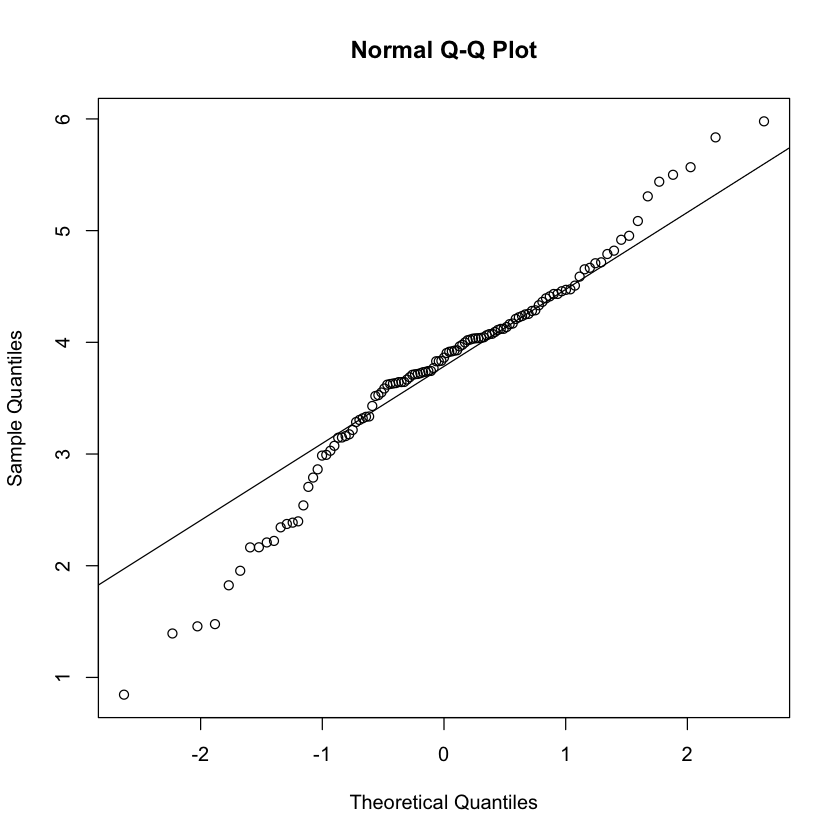

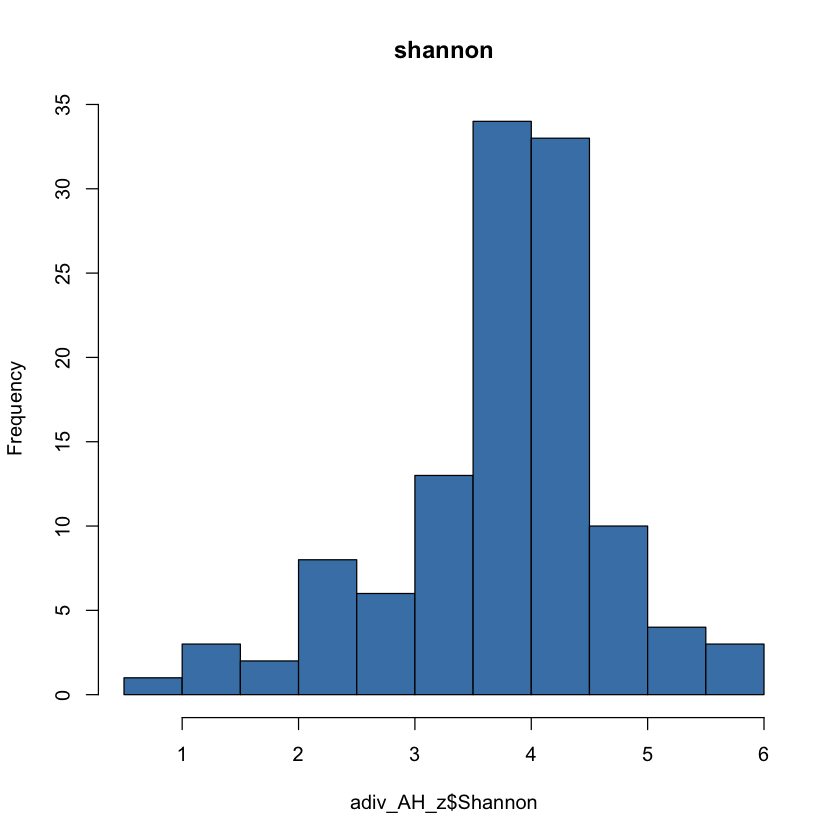

In [14]:
#inspect if data has a normal distribution
qqnorm(adiv_AH_z$Shannon)
qqline(adiv_AH_z$Shannon)
shapiro.test(adiv_AH_z$Shannon)
hist(adiv_AH_z$Shannon, col='steelblue', main='shannon')

,Shannon,Shannon_trans
,<dbl>,<dbl>
R3S7A1,5.085976,1.4519698
R3S7A2,3.830418,0.0903059
R3S7A3,4.820535,1.1640967
R3S7A4,3.903985,0.1700894
R3S7A5,4.953705,1.3085202
R3S7C1,4.507851,0.8249875



	Shapiro-Wilk normality test

data:  adiv_trans$Shannon_trans
W = 0.9624, p-value = 0.002332


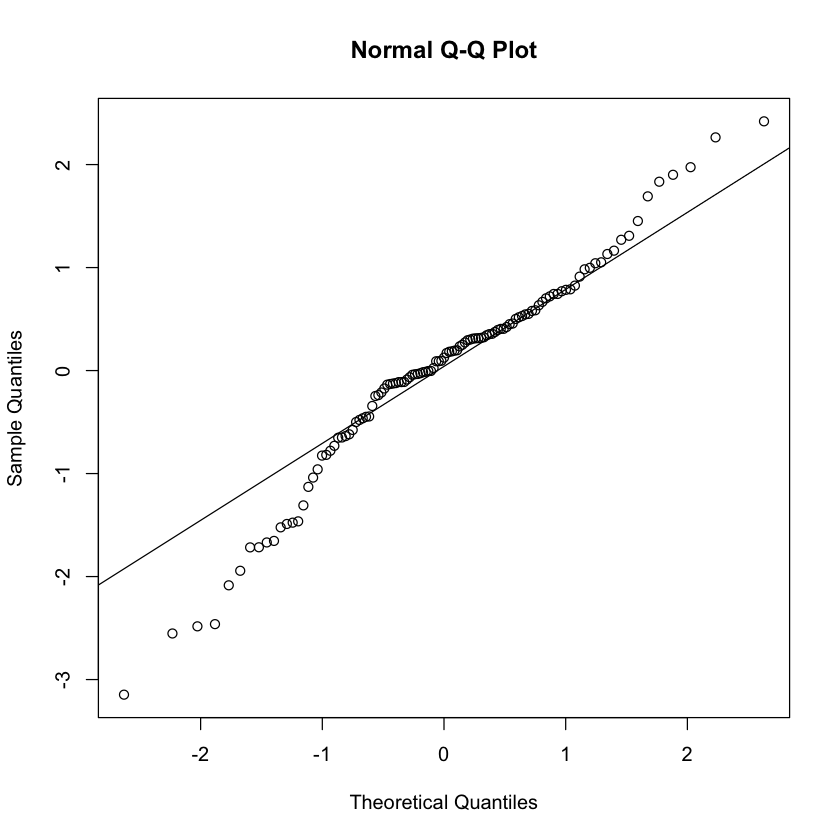

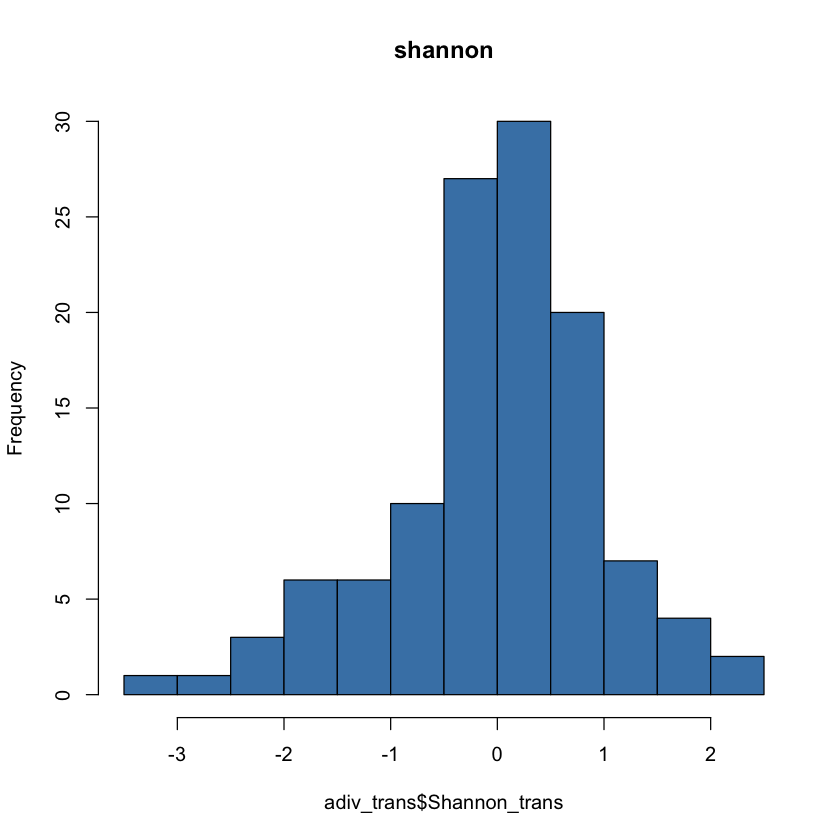

In [15]:
#normalize the data
adiv_trans =adiv_AH_z %>%
mutate(Shannon_trans = (Shannon - mean(Shannon)) / sd(Shannon))
head(adiv_trans)

#inspect normalized data
qqnorm(adiv_trans$Shannon_trans)
qqline(adiv_trans$Shannon_trans)
shapiro.test(adiv_trans$Shannon_trans)
hist(adiv_trans$Shannon_trans, col='steelblue', main='shannon')

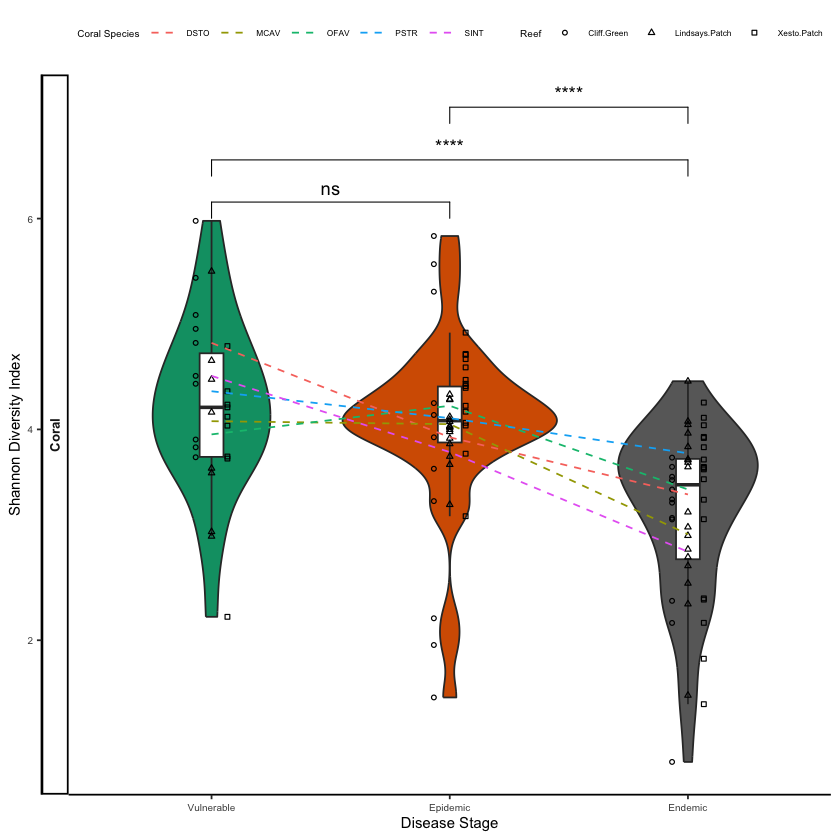

In [16]:
#Plot Shannon diversity for corals
# Define comparisons for statistical analysis
my_comparisons <- list(
  c("Vulnerable", "Epidemic"),
  c("Vulnerable", "Endemic"),
  c("Endemic", "Epidemic")
)

# Define color palette
cbPalette <- c("#009E73", "#D55E00", "#696969")

# Create alpha diversity plot
Fig_alpha_c <- ggplot(alpha_envs_AH_rare, aes(x = Site.Status, y = Shannon)) +
  geom_violin(aes(fill = Site.Status)) +  # Violin plot for distribution
  geom_boxplot(width = 0.1, outlier.shape = NA) +  # Boxplot overlay without outliers
  geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.2), size = 1) +  # Points with different shapes
  stat_summary(
    fun = median,
    geom = "line",
    linetype = "dashed",
    aes(group = Species_sample, color = Species_sample)
  ) +  # Dashed line for median per species sample
  
  # Customize scales
  scale_shape_manual(values = c(1, 2, 0)) +  
  scale_fill_manual(values = cbPalette) +
  
  # Facet by type
  facet_grid(Type ~ ., switch = "y") +
  
  # Labels
  xlab("Disease Stage") +
  ylab("Shannon Diversity Index") +
  
  # Theme adjustments
  theme_classic() +
  theme(
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title = element_text(size = 9),
    axis.text.x = element_text(size = 6),
    axis.text.y = element_text(size = 6),
    legend.position = "top",
    strip.text = element_text(size = 8, face = "bold")
  ) +
  
  # Legends
  guides(
    fill = "none",
    shape = guide_legend(title = "Reef"),
    color = guide_legend(title = "Coral Species")
  ) +
  
  # Statistical comparisons
  stat_compare_means(
    comparisons = my_comparisons,
    label.y = c(5.9, 6.3, 6.8),
    aes(label = after_stat(p.signif))
  )

Fig_alpha_c


In [17]:
# rarefy water based on the minimum number of reads in samples
ps_rare_w <- phyloseq::rarefy_even_depth(ps_wat_z, rngseed = 123, replace = FALSE, sample.size=46353)         

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

396OTUs were removed because they are no longer 
present in any sample after random subsampling


...



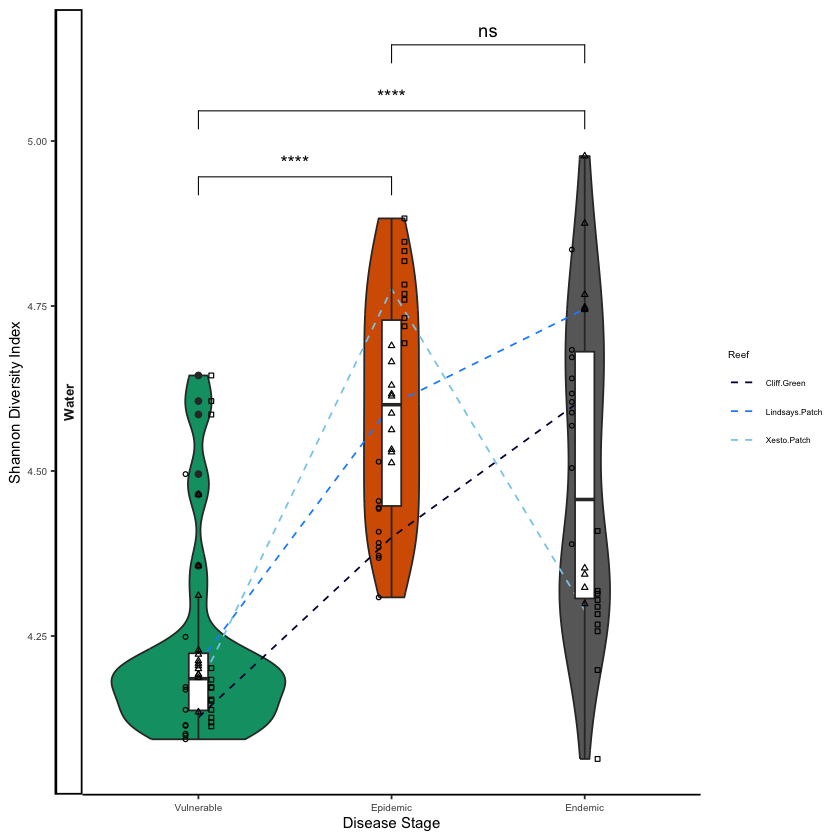

In [18]:
# Calculate Shannon diversity index
adiv_w_z <- data.frame(
  Shannon = phyloseq::estimate_richness(ps_rare_w, measures = "Shannon")
)

# Extract unique site names and assign shape mappings
site_names <- unique(alpha_envs_AH_rare$Site.Name)
shapes <- setNames(c(1, 2, 0), site_names)  # Ensure only 3 unique sites are mapped

# Combine with environmental metadata
ps_rare_w_meta <- as(sample_data(ps_rare_w), "data.frame")
alpha_w_rare <- cbind(ps_rare_w_meta, adiv_w_z)

# Create alpha diversity plot
Fig_alpha_w <- ggplot(alpha_w_rare, aes(x = Site.Status, y = Shannon)) +
  # Violin plot for distribution
  geom_violin(aes(fill = Site.Status)) +
  
  # Median summary with dashed lines
  stat_summary(
    fun = median,
    geom = "line",
    linetype = "dashed",
    aes(group = Site.Name, color = Site.Name)
  ) +
  
  # Customize colors and shapes
  scale_color_manual(values = c("#000042", "#1E90FF", "#87CEEB")) +
  scale_shape_manual(values = c(1, 2, 0)) +
  scale_fill_manual(values = cbPalette) +
  
  # Boxplot overlay
  geom_boxplot(width = 0.1) +
  
  # Points with different shapes
  geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.2), size = 1) +
  
  # Facet by Type
  facet_grid(Type ~ ., switch = "y") +
  
  # Labels
  xlab("Disease Stage") +
  ylab("Shannon Diversity Index") +
  
  # Theme adjustments
  theme_classic() +
  theme(
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title.x = element_text(size = 9),
    axis.title.y = element_text(size = 9),
    axis.text.x = element_text(size = 6),
    axis.text.y = element_text(size = 6),
    strip.text = element_text(size = 8, face = "bold")
  ) +
  
  # Legends
  guides(
    fill = "none",
    color = guide_legend(title = "Reef"),
    shape = "none"  # Hide shape legend
  ) +
  
  # Statistical comparisons
  stat_compare_means(
    comparisons = my_comparisons,
    label.y = c(4.9, 5.0, 5.1),
    aes(label = after_stat(p.signif))
  )

# Display plot
Fig_alpha_w


In [19]:
# rarefy sediment based on the minimum number of reads in samples
ps_rare_s <- phyloseq::rarefy_even_depth(ps_sed_z, rngseed = 123, replace = FALSE, sample.size=14294)         

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

193OTUs were removed because they are no longer 
present in any sample after random subsampling


...



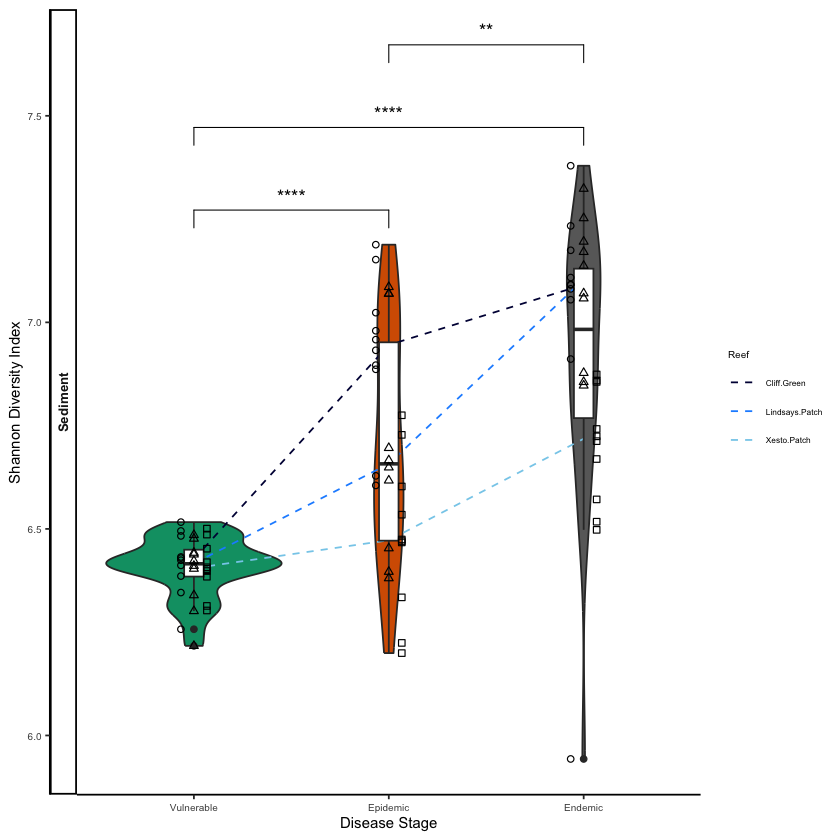

In [20]:
# Calculate Shannon diversity index
adiv_s_z <- data.frame(
  Shannon = phyloseq::estimate_richness(ps_rare_s, measures = "Shannon")
)

# Combine with environmental metadata
ps_rare_s_meta <- as(sample_data(ps_sed_z), "data.frame")
alpha_s_rare <- cbind(ps_rare_s_meta, adiv_s_z)

# Create alpha diversity plot
Fig_alpha_s <- ggplot(alpha_s_rare, aes(x = Site.Status, y = Shannon)) +
  # Violin plot for distribution
  geom_violin(aes(fill = Site.Status)) +
  
  # Median summary with dashed lines
  stat_summary(
    fun = median,
    geom = "line",
    linetype = "dashed",
    aes(group = Site.Name, color = Site.Name)
  ) +
  
  # Customize colors and shapes
  scale_color_manual(values = c("#000042", "#1E90FF", "#87CEEB")) +
  scale_shape_manual(values = c(1, 2, 0)) +
  scale_fill_manual(values = cbPalette) +
  
  # Boxplot overlay
  geom_boxplot(width = 0.1) +
  
  # Points with different shapes
  geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.2)) +
  
  # Facet by Type
  facet_grid(Type ~ ., switch = "y") +
  
  # Labels
  xlab("Disease Stage") +
  ylab("Shannon Diversity Index") +
  
  # Theme adjustments
  theme_classic() +
  theme(
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title.x = element_text(size = 9),
    axis.title.y = element_text(size = 9),
    axis.text.x = element_text(size = 6),
    axis.text.y = element_text(size = 6),
    strip.text = element_text(size = 8, face = "bold")
  ) +
  
  # Legends
  guides(
    fill = "none",
    color = guide_legend(title = "Reef"),
    shape = "none"  # Hide shape legend
  ) +
  
  # Statistical comparisons
  stat_compare_means(
    comparisons = my_comparisons,
    label.y = c(7.2, 7.4, 7.6),
    aes(label = after_stat(p.signif))
  )

# Display plot
Fig_alpha_s



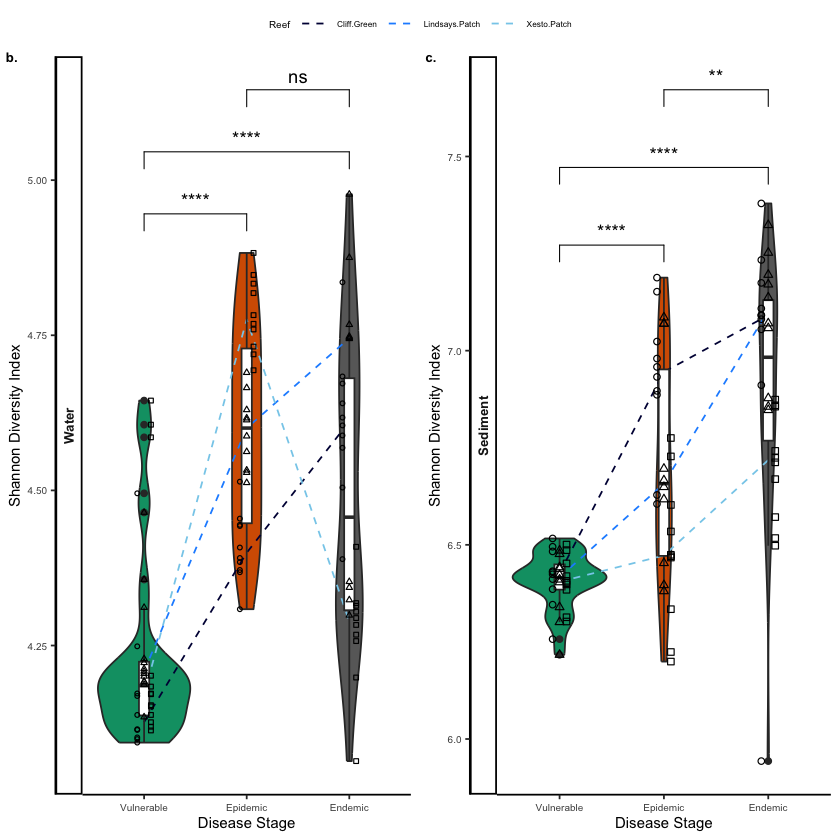

In [21]:
Fig_w_s=ggarrange( Fig_alpha_w, Fig_alpha_s, nrow = 1, ncol=2, common.legend = TRUE, legend="top",
                           labels = c("b.","c."),
                  font.label = list(size = 8, color = "black"))
Fig_w_s

## Figure 2

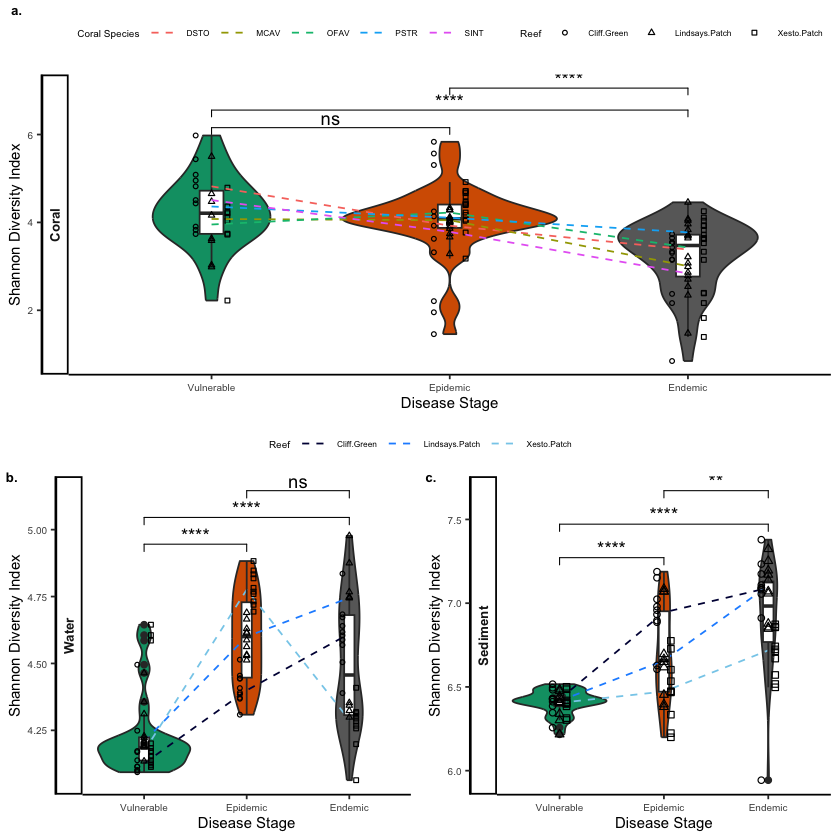

In [22]:
ggarrange(Fig_alpha_c, Fig_w_s, nrow = 2, ncol=1, common.legend = FALSE, legend="top",
                           labels = c(" a."),
          font.label = list(size = 8, color = "black"))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure2.png",
   width = 7, height = 8, units = "in", dpi=300)
     


## linear mixed models

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + Season + (1 | Species_sample) + (1 |  
    Site.Name)
   Data: alpha_envs_AH_rare

REML criterion at convergence: 283.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1395 -0.5141  0.2215  0.5346  2.2209 

Random effects:
 Groups         Name        Variance  Std.Dev.
 Species_sample (Intercept) 0.0361451 0.19012 
 Site.Name      (Intercept) 0.0008029 0.02833 
 Residual                   0.6217261 0.78850 
Number of obs: 117, groups:  Species_sample, 5; Site.Name, 3

Fixed effects:
                    Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)           3.9100     0.2817 24.4048  13.878 4.44e-13 ***
Site.StatusEpidemic   0.1333     0.2921 63.6861   0.456   0.6497    
Site.StatusEndemic   -0.7057     0.2888 65.3126  -2.444   0.0172 *  
Seasonwet             0.4849     0.3304 32.4162   1.468   0.1519    
---
Signif. codes:  0 ‘***’ 0.00


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + Season + (1 | Species_sample) + 
    (1 | Site.Name), data = alpha_envs_AH_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)    
Epidemic - Vulnerable == 0   0.1333     0.2921   0.456   0.8883    
Endemic - Vulnerable == 0   -0.7057     0.2888  -2.444   0.0364 *  
Endemic - Epidemic == 0     -0.8390     0.1666  -5.035   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                           Estimate
Epidemic - Vulnerable == 0   0.1333
Endemic - Vulnerable == 0   -0.7057
Endemic - Epidemic == 0     -0.8390


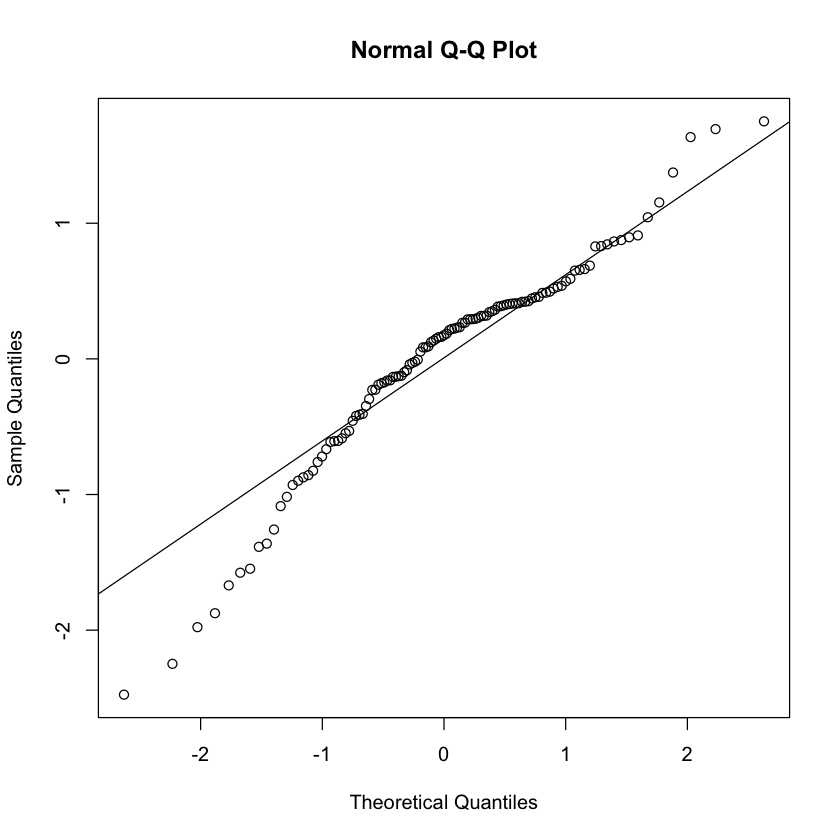

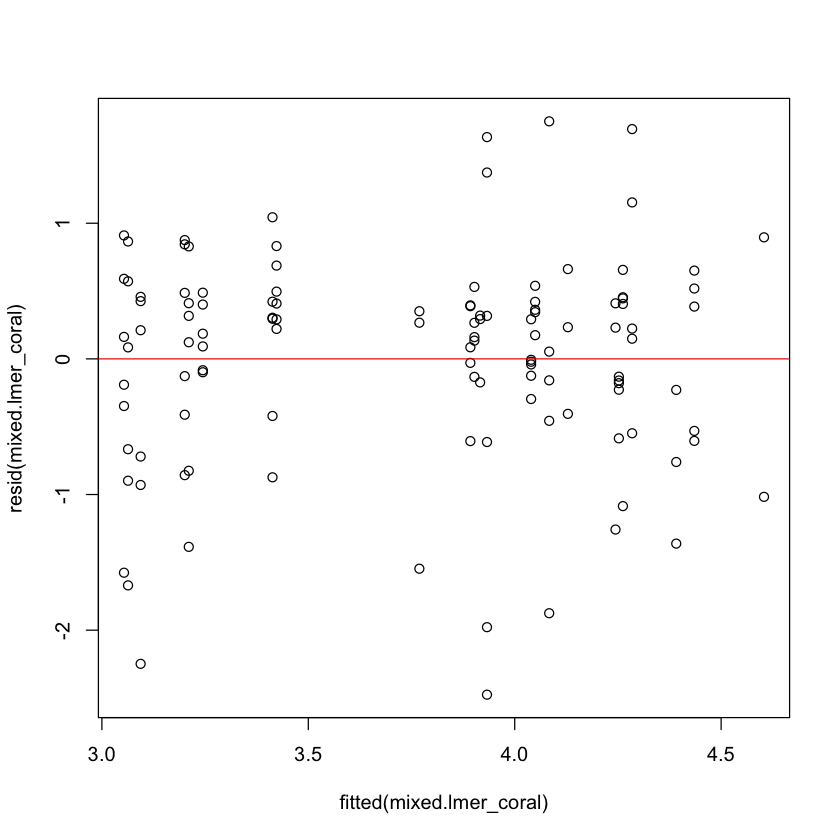

In [23]:
# Fit mixed-effects model for corals
mixed.lmer_coral <- lmer(Shannon ~ Site.Status + Season + 
                         (1 | Species_sample) + (1 | Site.Name), 
                         data = alpha_envs_AH_rare)

# Summarize the model
summary(mixed.lmer_coral)

# Post-hoc test for Site.Status
posthoc <- glht(mixed.lmer_coral, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)
posthoc

# Q-Q plot for residuals
qqnorm(resid(mixed.lmer_coral))
qqline(resid(mixed.lmer_coral))

# Residuals vs fitted plot
plot(fitted(mixed.lmer_coral), resid(mixed.lmer_coral))
abline(h = 0, col = "red")


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + Season + (1 | Site.Name)
   Data: alpha_s_rare

REML criterion at convergence: -2.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9479 -0.4909  0.0258  0.6259  1.7835 

Random effects:
 Groups    Name        Variance Std.Dev.
 Site.Name (Intercept) 0.01610  0.1269  
 Residual              0.04766  0.2183  
Number of obs: 90, groups:  Site.Name, 3

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)          6.40614    0.08339  2.78101  76.820 1.04e-05 ***
Site.StatusEpidemic  0.29862    0.05637 85.00000   5.298 9.08e-07 ***
Site.StatusEndemic   0.52316    0.05637 85.00000   9.282 1.45e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) St.SttsEp
St.SttsEpdm -0.338          
St.SttsEndm -0.338  0.500   
fit warnings:
fixed-effect model 


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + Season + (1 | Site.Name), 
    data = alpha_s_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)    
Epidemic - Vulnerable == 0  0.29862    0.05637   5.298  < 1e-04 ***
Endemic - Vulnerable == 0   0.52316    0.05637   9.282  < 1e-04 ***
Endemic - Epidemic == 0     0.22455    0.05637   3.984 0.000216 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


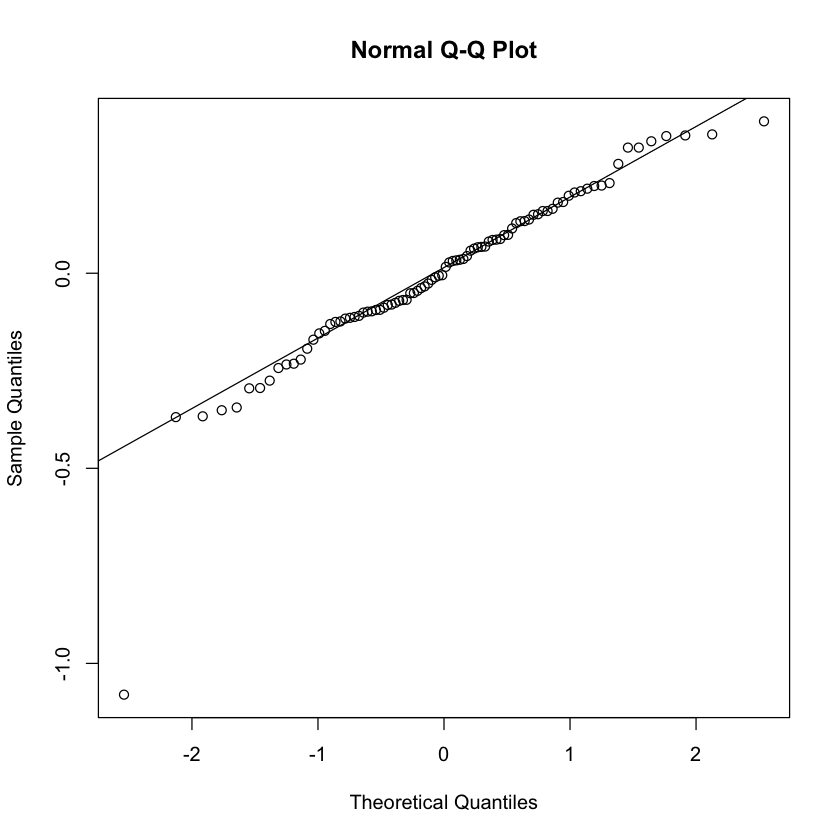

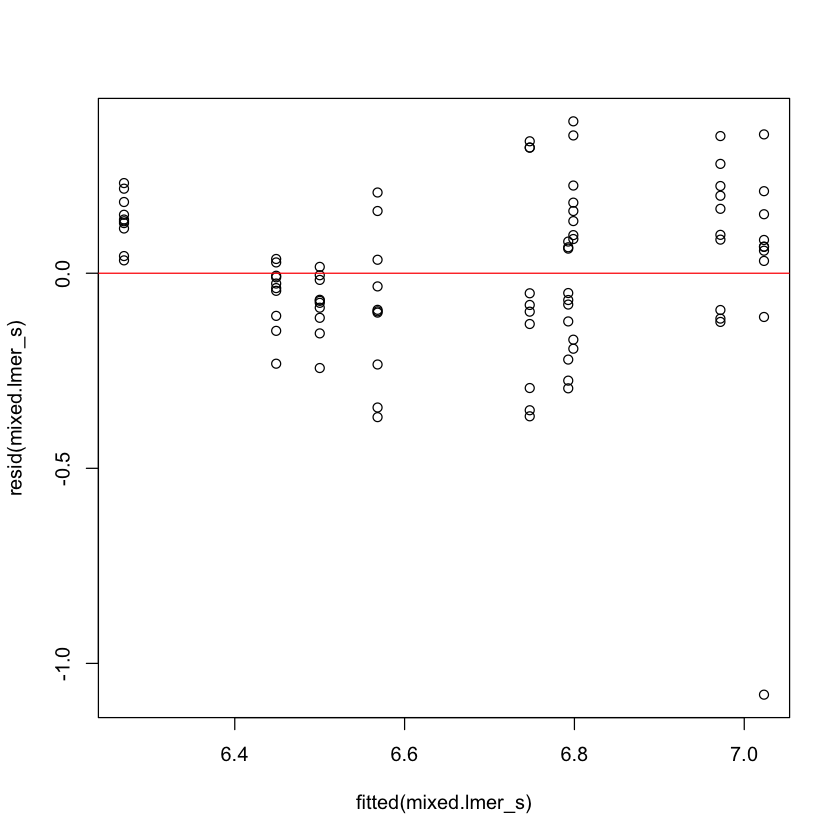

In [24]:
# Fit mixed-effects model for sediment
mixed.lmer_s <- lmer(Shannon ~ Site.Status + Season   + (1|Site.Name), data =alpha_s_rare)
summary(mixed.lmer_s)

posthoc <- glht(mixed.lmer_s, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)


qqnorm(resid(mixed.lmer_s))
qqline(resid(mixed.lmer_s))

plot(fitted(mixed.lmer_s), resid(mixed.lmer_s))
abline(h = 0, col = "red")


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + Season + (1 | Site.Name)
   Data: alpha_w_rare

REML criterion at convergence: -54.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5127 -0.5873 -0.1238  0.6960  2.6494 

Random effects:
 Groups    Name        Variance Std.Dev.
 Site.Name (Intercept) 0.001445 0.03802 
 Residual              0.027969 0.16724 
Number of obs: 96, groups:  Site.Name, 3

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)          4.62787    0.10089 71.69365  45.870  < 2e-16 ***
Site.StatusEpidemic -0.03247    0.10310 91.99880  -0.315    0.754    
Site.StatusEndemic  -0.12814    0.10310 91.99880  -1.243    0.217    
Seasonwet           -0.43728    0.10286 91.96837  -4.251  5.1e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) St.SttsEp St.SttsEn
St.SttsEpd


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + Season + (1 | Site.Name), 
    data = alpha_w_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)  
Epidemic - Vulnerable == 0 -0.03247    0.10310  -0.315   0.9439  
Endemic - Vulnerable == 0  -0.12814    0.10310  -1.243   0.4102  
Endemic - Epidemic == 0    -0.09567    0.04318  -2.216   0.0622 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


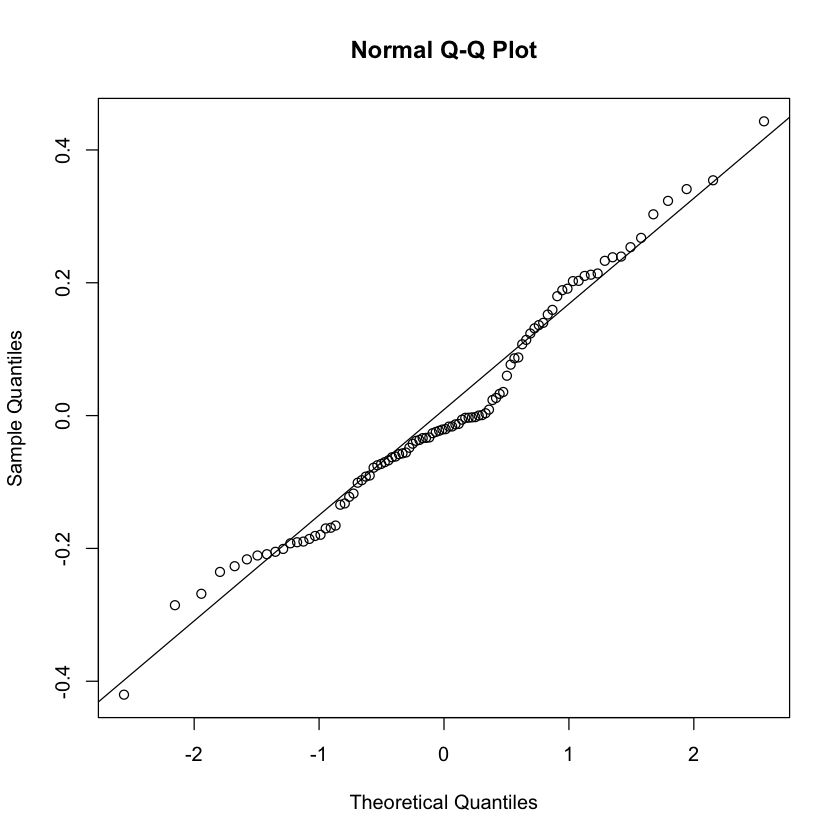

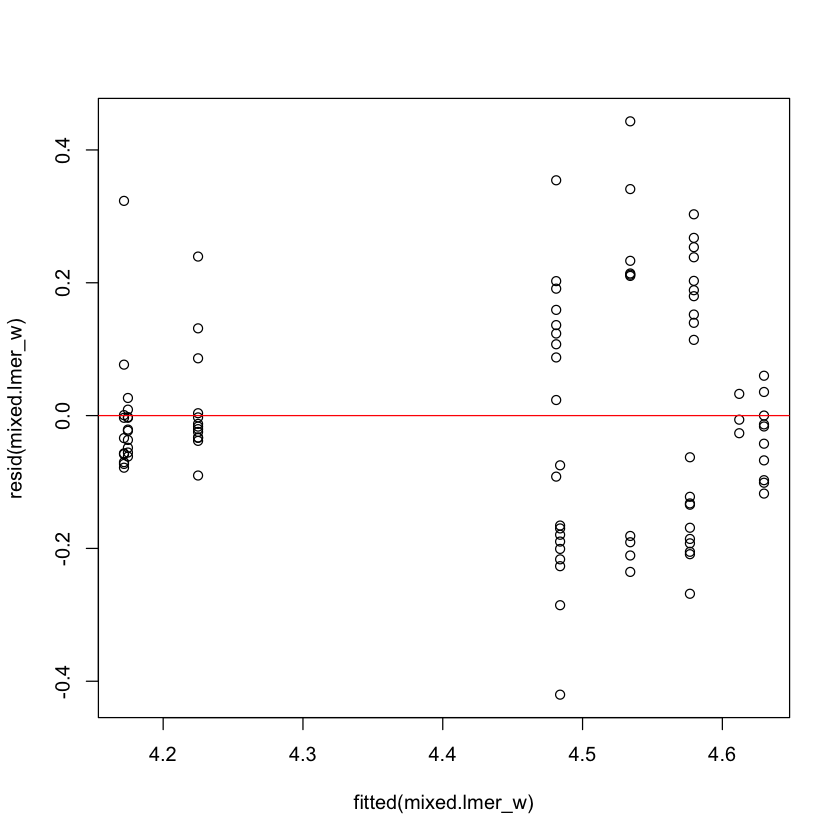

In [25]:
# Fit mixed-effects model for water

mixed.lmer_w <- lmer(Shannon ~ Site.Status  + Season + (1|Site.Name) , data =alpha_w_rare)
summary(mixed.lmer_w)

posthoc <- glht(mixed.lmer_w, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)


qqnorm(resid(mixed.lmer_w))
qqline(resid(mixed.lmer_w))

plot(fitted(mixed.lmer_w), resid(mixed.lmer_w))
abline(h = 0, col = "red")

In [26]:
R.version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          4.1                         
year           2024                        
month          06                          
day            14                          
svn rev        86737                       
language       R                           
version.string R version 4.4.1 (2024-06-14)
nickname       Race for Your Life          